### Disclaimer: The model in this Notebook was developed by Omar Askar. However, the outline, problem, and structure of the notebook is provided by Coursera's Deep Learning course staff (Andrew Ng, et al.), as part of the programming assignment required to complete the online course.

# Section 1: Preparation of Helper Functions

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

### 1.1 - Linear function

Let's compute the following equation: $Y = WX + b$, where $W$ and $X$ are random matrices and b is a random vector. 

In [8]:
def linear_function():
    """
    Implements a linear function: 
            Initializes W to be a random tensor of shape (4,3)
            Initializes X to be a random tensor of shape (3,1)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- runs the session for Y = WX + b 
    """
    
    np.random.seed(1)
    X = tf.constant(np.random.randn(3,1), name = "X")
    W = tf.constant(np.random.randn(4,3), name = "W")
    b = tf.constant(np.random.randn(4,1), name = "b")
    Y = tf.add(tf.matmul(W,X), b)
    
    # Create the session using tf.Session() and run it with sess.run(...) on the variable you want to calculate
    sess = tf.Session()
    result = sess.run(Y)
    
    sess.close()

    return result

### 1.2 - Computing the sigmoid 
Similarly, below I'll implement a function that computes the sigmoid of an input. 

In [13]:
def sigmoid(z):
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    results -- the sigmoid of z
    """
    # Create a placeholder for x. Name it 'x'.
    x = tf.placeholder(tf.float32, name = "x")

    # compute sigmoid(x)
    sigmoid = tf.sigmoid(x)

    # Create a session, and run it. Please use the method 2 explained above. 
    with tf.Session() as sess: 
        # Run session and call the output "result"
        result = sess.run(sigmoid, feed_dict = {x: z})    
    return result

### 1.3 -  Computing the Cost

We can also use a built-in function to compute the cost of a neural network. I'll use TensorFlow's implementation of the cost function as follows..

In [15]:
def cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy
    
    Arguments:
    logits -- vector containing z, output of the last linear unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0) 
    
    Note: What we've been calling "z" and "y" in this class are respectively called "logits" and "labels" 
    in the TensorFlow documentation. So logits will feed into z, and labels into y. 
    
    Returns:
    cost -- runs the session of the cost (formula (2))
    """
    
    # Create the placeholders for "logits" (z) and "labels" (y) (approx. 2 lines)
    z = tf.placeholder(tf.float32, name = "z")
    y = tf.placeholder(tf.float32, name = "y")
    
    # Use the loss function (approx. 1 line)
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits = z,  labels = y)
    
    # Create a session (approx. 1 line). See method 1 above.
    sess = tf.Session()
    
    # Run the session (approx. 1 line).
    cost = sess.run(cost, feed_dict = {z: logits, y: labels})

    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
        
    return cost

### 1.4 - Using One Hot encodings


Let's Implement the function below to take one vector of labels and the total number of classes $C$, and return the one hot encoding. We will need this function later to transform matrices.

In [66]:

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j) 
                     will be 1. 
                     
    Arguments:
    labels -- vector containing the labels 
    C -- number of classes, the depth of the one hot dimension
    
    Returns: 
    one_hot -- one hot matrix
    """
    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name='C')
    
    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(labels, C, axis=0)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session (approx. 1 line).
    one_hot = sess.run(one_hot_matrix)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    return one_hot

### 1.5 - Initialize with zeros and ones

In [4]:

def ones(shape):
    """
    Creates an array of ones of dimension shape
    
    Arguments:
    shape -- shape of the array you want to create
        
    Returns: 
    ones -- array containing only ones
    """
    
    # Create "ones" tensor using tf.ones(...). (approx. 1 line)
    ones = tf.ones(shape)
    
    # Create the session (approx. 1 line)
    sess = tf.Session()
    
    # Run the session to compute 'ones' (approx. 1 line)
    ones = sess.run(ones)
    
    # Close the session (approx. 1 line). See method 1 above.
    sess.close()
    
    return ones

Now that we have the helper functions we need, let's go ahead and start implementing the model that will use those functions

# 2 - Building your first neural network in tensorflow


### 2.0 - Problem statement: SIGNS Dataset

The dataset consists of images of numbers sign language taken in front of a white wall. The goal of this model is to facilitate communications from a speech-impaired person to someone who doesn't understand sign language.

- **Training set**: 1080 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (180 pictures per number).
- **Test set**: 120 pictures (64 by 64 pixels) of signs representing numbers from 0 to 5 (20 pictures per number).


In [2]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

Change the index below and run the cell to visualize some examples in the dataset.

I'll flatten the image dataset to be able to feed it properly to the network. I'll then normalize it by dividing by 255. Also I will convert each label to a one-hot vector.

In [4]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 6)
Y_test = convert_to_one_hot(Y_test_orig, 6)

print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


**The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX.

### 2.1 - Create placeholders

Our first task is to create placeholders for `X` and `Y`. This will allow to later pass the training data in while running a session.

In [5]:

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None), name = 'Placeholder_1')
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name = 'Placeholder_2')
    
    return X, Y

### 2.2 - Initializing the parameters

Then let's initialize the parameters in tensorflow.

In [7]:

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    W1 = tf.get_variable("W1", [25,12288], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

### 2.3 - Forward propagation in tensorflow 

Let's now implement the forward propagation module in tensorflow. 

In [9]:

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.add(tf.matmul(W1,X),b1)  
    A1 = tf.nn.relu(Z1)             
    Z2 = tf.add(tf.matmul(W2,A1),b2) 
    A2 = tf.nn.relu(Z2)       
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3

### 2.4 Compute cost


In [11]:

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

### 2.5 - Backward propagation & parameter updates

In TensorFlow, the Optimizer object calculates the backpropagation for us.
For example, for Gradient Decent, optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)

### 2.6 - Building the model

Now, let's bring it all together! 

In [13]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.016458
Cost after epoch 200: 0.733102
Cost after epoch 300: 0.572940
Cost after epoch 400: 0.468774
Cost after epoch 500: 0.381021
Cost after epoch 600: 0.313822
Cost after epoch 700: 0.254158
Cost after epoch 800: 0.203829
Cost after epoch 900: 0.166421
Cost after epoch 1000: 0.141486
Cost after epoch 1100: 0.107580
Cost after epoch 1200: 0.086270
Cost after epoch 1300: 0.059371
Cost after epoch 1400: 0.052228


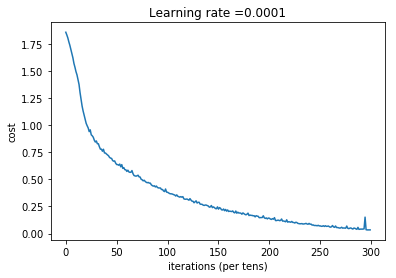

Parameters have been trained!
Train Accuracy: 0.999074
Test Accuracy: 0.716667


In [14]:
parameters = model(X_train, Y_train, X_test, Y_test)